In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import tensorflow as tf

import re
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
df = pd.read_csv("C:/Users/RYuK/traintweet.csv", header=None)

In [6]:
df.head()

,sentiment,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = df.rename(columns={0: 'sentiment', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})

In [7]:
df.head()

,sentiment,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.isna().sum()

sentiment    0
id           0
date         0
query        0
username     0
content      0
dtype: int64

In [9]:
del df['id']
del df['date']
del df['query']
del df['username']

In [10]:
df.head()

,sentiment,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [12]:
df.sentiment = df.sentiment.replace({4 : 1, 0 : 0})

In [ ]:
# 0 : Negative & 1 : Positive

In [14]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

In [15]:
from keras.utils import to_categorical

target = df.sentiment.values
y_target = to_categorical(target)

# number of numerical values exist in y_target's column
num_classes = y_target.shape[1]
print(num_classes)

2


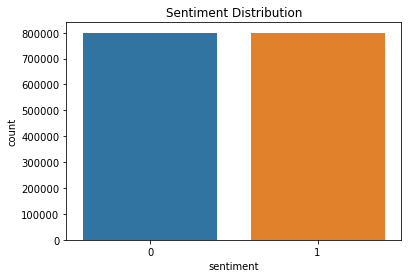

In [17]:
ax = plt.axes()
sns.countplot(df.sentiment,ax=ax)
ax.set_title('Sentiment Distribution')
plt.show()

# Data Cleaning

In [18]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"http\S+", "", phrase)
    return phrase

In [19]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
                'won', "won't", 'wouldn', "wouldn't"])

In [20]:
def clean_sentences(df):
    reviews = []
    
    for sent in tqdm(df['content']):       
        #remove non-alphabetic characters
        sent = decontracted(sent)
        review_text = re.sub("[^a-zA-Z]"," ", sent)
        review_text = re.sub("\S*\d\S*", "", review_text).strip()
        review_text = ' '.join(e.lower() for e in review_text.split() if e.lower() not in stopwords)
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
        
        #lemmatize each word to its lemma
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
    
    return(reviews)

In [21]:
%%time
train_sentences = clean_sentences(df)

print(len(train_sentences))

100%|██████████████████████████████████████████████████████████████████████| 1600000/1600000 [03:57<00:00, 6743.24it/s]

1600000
Wall time: 3min 57s


In [22]:
print(df['content'][100])
print(' '.join(train_sentences[100]))

 Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji
body missing northern calif girl found police found remains missing northern california girl


# Model Trainig

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_sentences,
                                                  y_target,
                                                  test_size = 0.2,
                                                  stratify = y_target)

In [26]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)

# length of the list of unique_words 
vocab_size = len(list(unique_words))
print('Number of vocabs: ', vocab_size)
print('Max length of text is: ', len_max)

100%|████████████████████████████████████████████████████████████████████| 1280000/1280000 [00:03<00:00, 329573.22it/s]

Number of vocabs:  472867
Max length of text is:  50


In [27]:
tokenized = Tokenizer(num_words= vocab_size,oov_token="<oov>")
tokenized.fit_on_texts(X_train)

tokenized.fit_on_texts(list(X_train))

#word index
word_index = tokenized.word_index

#Tokenizing and padding train sequence
X_train = tokenized.texts_to_sequences(X_train)

X_train = pad_sequences(X_train,maxlen = len_max,truncating= 'post',padding='post')

#Tokenizing and padding test sequences
X_test = tokenized.texts_to_sequences(X_test)

X_test = pad_sequences(X_test,maxlen = len_max,truncating= 'post',padding='post')

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=len_max),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),#here we add a return sequences parameter so that its output will match input of 2nd layer 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')])



model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            7567392   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 50        
Total params: 7,651,690
Trainable params: 7,651,690
Non-trainable params: 0
_________________________________________________________________


In [28]:
num_epochs = 5
history = model.fit(x = X_train,y= y_train,epochs=num_epochs,validation_data=(X_test,y_test)).history

Epoch 1/5
40000/40000 [==============================] - 3319s 83ms/step - loss: 0.4575 - accuracy: 0.7819 - val_loss: 0.4074 - val_accuracy: 0.8133
Epoch 2/5
40000/40000 [==============================] - 3348s 84ms/step - loss: 0.3336 - accuracy: 0.8570 - val_loss: 0.4680 - val_accuracy: 0.7872
Epoch 3/5
40000/40000 [==============================] - 3305s 83ms/step - loss: 0.2665 - accuracy: 0.8885 - val_loss: 0.5326 - val_accuracy: 0.7759
Epoch 4/5
40000/40000 [==============================] - 3281s 82ms/step - loss: 0.2381 - accuracy: 0.9001 - val_loss: 0.5268 - val_accuracy: 0.7851
Epoch 5/5
40000/40000 [==============================] - 3237s 81ms/step - loss: 0.2184 - accuracy: 0.9085 - val_loss: 0.5393 - val_accuracy: 0.7847


In [29]:
# Saving our model progress
model.save('SentAnalysiModel01.h5')
pickle.dump(history , open("SentAnalysiModel.p", "wb"))

In [30]:
#Loading model
model = load_model("C:/Users/RYuK/SentAnalysiModel01.h5")
history = pickle.load(open("C:/Users/RYuK/SentAnalysiHistory.p", 'rb'))

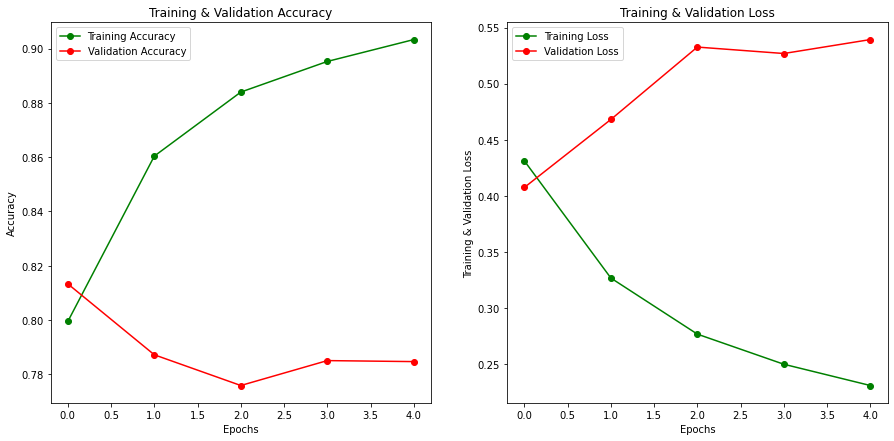

In [30]:
epochs = [i  for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']
fig.set_size_inches(15,7)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [69]:
accr1 = model.evaluate(X_test,y_test)

10000/10000 [==============================] - 80s 8ms/step - loss: 0.9644 - accuracy: 0.5985


In [72]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]*100))

Test set
  Accuracy: 59.85


In [32]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61    160000
           1       0.61      0.56      0.58    160000

   micro avg       0.60      0.60      0.60    320000
   macro avg       0.60      0.60      0.60    320000
weighted avg       0.60      0.60      0.60    320000
 samples avg       0.60      0.60      0.60    320000

